# Predicting AirBnb prices with machine learning algorithm

## Overview
This research is conducted on datasets obtained by Gyódi, Kristóf and Nawaro, Łukasz.

This project focuses on predicting Airbnb prices in Europe using machine learning algorithm. Accurate price prediction is crucial for hosts to set competitive rates and maximize revenue, while travelers benefit from reliable estimates for budget planning. The Random Forest Regressor algorithm, known for its ensemble of decision trees, offers a robust solution. By analyzing historical data and considering factors like location, property type, and day of the week, the model can provide valuable insights into the factors influencing Airbnb prices. The project aims to benefit hosts and travelers in the European Airbnb market with accurate price predictions and informed decision-making.

<b>The columns in the datasets:

* realSum: the full price of accommodation for two people and two nights in EUR
* room_type: the type of the accommodation 
* room_shared: dummy variable for shared rooms
* room_private: dummy variable for private rooms
* person_capacity: the maximum number of guests 
* host_is_superhost: dummy variable for superhost status
* multi: dummy variable if the listing belongs to hosts with 2-4 offers
* biz: dummy variable if the listing belongs to hosts with more than 4 offers
* cleanliness_rating: cleanliness rating
* guest_satisfaction_overall: overall rating of the listing
* bedrooms: number of bedrooms (0 for studios)
* dist: distance from city centre in km
* metro_dist: distance from nearest metro station in km
* attr_index: attraction index of the listing location
* attr_index_norm: normalised attraction index (0-100)
* rest_index: restaurant index of the listing location
* attr_index_norm: normalised restaurant index (0-100)
* lng: longitude of the listing location
* lat: latitude of the listing location

## Data inspection
There are 20 csv files in this dataset. It is better to merge them in a single dataset to perform further research.

In [53]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Assigning csv files path to a variable and initiating dataframes dictionary
folder_path = 'archive'
dataframes = {}

In [3]:
# Iterating through every csv file and storing it in a dictionary with file name as a key
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        dataframe_name = os.path.splitext(file_name)[0]
        dataframes[dataframe_name] = df

In [4]:
# Creating a new column for each DataFrame with it's name
for key in dataframes.keys():
    dataframes[key]['geo'] = key

In [5]:
# Concatenating dataframes
df = pd.concat(dataframes.values()).reset_index()

In [6]:
# Splitting file name into two columns: geography and time of the week
df['week'] = df.geo.apply(lambda x: x.split('_')[1])
df['geo'] = df.geo.apply(lambda x: x.split('_')[0])

# Dropping columns
df = df.drop(['index', 'Unnamed: 0'], axis=1)

***
Now that we have a single dataframe, we can start data inspection

In [7]:
# Inspecting data
display(df.head())
display(df.info())

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,geo,week
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  bool   
 3   room_private                51707 non-null  bool   
 4   person_capacity             51707 non-null  float64
 5   host_is_superhost           51707 non-null  bool   
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  float64
 9   guest_satisfaction_overall  51707 non-null  float64
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

None

We have 5107 observations with no missing values. Every column data type is corresponding to its feature.

In [8]:
# Check for number of values in categorical columns
display(df.room_type.value_counts(normalize=True))
display(df.geo.value_counts(normalize=True))
display(df.week.value_counts(normalize=True))

Entire home/apt    0.631404
Private room       0.361518
Shared room        0.007078
Name: room_type, dtype: float64

london       0.193262
rome         0.174580
paris        0.129344
lisbon       0.111455
athens       0.102114
budapest     0.077784
vienna       0.068405
barcelona    0.054789
berlin       0.048040
amsterdam    0.040227
Name: geo, dtype: float64

weekends    0.506837
weekdays    0.493163
Name: week, dtype: float64

Categorical data ispection shows that shared rooms take less than 1 percent of the database. It would be reasonable to drop these rows since this few observations may be biased. There are also boolean columns that duplicate information in 'room_type' column. I will delete them too.
Geography and time of the week are distributed evenly enough.

In [9]:
# Deleting 'shared room' rows
df.drop(labels=df[df.room_type == 'Shared room'].index, inplace=True)

# Deleting 'room_shared' and 'room_private' columns
df.drop(columns=['room_shared', 'room_private'], inplace=True)
df = df.reset_index(drop=True)
display(df)

,realSum,room_type,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,geo,week
0,194.033698,Private room,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,amsterdam,weekdays
1,344.245776,Private room,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,amsterdam,weekdays
2,264.101422,Private room,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,amsterdam,weekdays
3,433.529398,Private room,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,amsterdam,weekdays
4,485.552926,Private room,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,amsterdam,weekdays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51336,1035.066676,Private room,2.0,False,0,1,10.0,100.0,0,5.155373,0.883829,271.191201,18.851558,528.042180,9.451035,-0.05357,51.51255,london,weekends
51337,181.095510,Private room,2.0,False,1,0,10.0,100.0,1,5.072177,0.344055,268.165870,18.641255,554.906232,9.931855,-0.05620,51.51823,london,weekends
51338,420.517886,Entire home/apt,2.0,False,0,0,10.0,98.0,1,6.709982,0.926188,181.892001,12.644022,395.397885,7.076933,-0.22172,51.52180,london,weekends
51339,217.314612,Private room,2.0,False,0,0,10.0,94.0,1,6.736940,0.353634,184.278328,12.809905,471.029678,8.430610,-0.22286,51.49715,london,weekends


It will be reasonable to round the 'realSum' values to zero decimals and distance columns to two decimals. Data inspection showed that latitude and longitude were used by the authors to find attraction index and restaurant index so we can get rid of them.

In [10]:
# Rounding decimal features
df['realSum'] = df['realSum'].apply(lambda x: round(x, 0))
df['dist'] = df['dist'].apply(lambda x: round(x, 2))
df['metro_dist'] = df['metro_dist'].apply(lambda x: round(x, 2))

# Dropping longitude and latitude
df.drop(columns=['lng', 'lat'], inplace=True)
df = df.reset_index(drop=True)

Even though we have checked that there are no missing values, there is still a chance that missing data could be inputed in some other way. I will look into the unique values to be sure.

In [11]:
# Removing rows and columns display limit
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Printing unique values for every column
for i in df.columns:
    display(i)
    display(df[i].value_counts())

'realSum'

162.0     671
139.0     549
116.0     464
127.0     464
104.0     428
         ... 
2174.0      1
978.0       1
1613.0      1
1109.0      1
2329.0      1
Name: realSum, Length: 1386, dtype: int64

'room_type'

Entire home/apt    32648
Private room       18693
Name: room_type, dtype: int64

'person_capacity'

2.0    24193
4.0    13909
3.0     6136
6.0     4180
5.0     2923
Name: person_capacity, dtype: int64

'host_is_superhost'

False    38150
True     13191
Name: host_is_superhost, dtype: int64

'multi'

0    36351
1    14990
Name: multi, dtype: int64

'biz'

0    33453
1    17888
Name: biz, dtype: int64

'cleanliness_rating'

10.0    29928
9.0     15321
8.0      4295
7.0       933
6.0       490
2.0       141
4.0       137
5.0        86
3.0        10
Name: cleanliness_rating, dtype: int64

'guest_satisfaction_overall'

100.0    10624
98.0      3874
97.0      3617
96.0      3514
93.0      3304
         ...  
62.0         4
44.0         2
46.0         1
54.0         1
61.0         1
Name: guest_satisfaction_overall, Length: 53, dtype: int64

'bedrooms'

1     35967
2      9290
0      4485
3      1477
4        96
5        10
9        10
6         2
8         2
10        2
Name: bedrooms, dtype: int64

'dist'

1.12     186
1.43     169
0.94     163
0.88     153
0.95     152
        ... 
13.50      1
11.44      1
19.79      1
13.35      1
12.20      1
Name: dist, Length: 1318, dtype: int64

'metro_dist'

0.24    912
0.18    903
0.27    892
0.30    892
0.32    865
       ... 
6.11      1
4.69      1
5.84      1
4.64      1
9.17      1
Name: metro_dist, Length: 649, dtype: int64

'attr_index'

78.690379     1
53.926032     1
378.823765    1
140.988085    1
51.675089     1
             ..
373.508553    1
400.555991    1
272.235986    1
349.696990    1
434.954210    1
Name: attr_index, Length: 51341, dtype: int64

'attr_index_norm'

100.000000    20
4.166708       1
6.153742       1
1.948366       1
14.516765      1
              ..
13.211645      1
8.979232       1
11.534149      1
9.322951       1
30.235363      1
Name: attr_index_norm, Length: 51322, dtype: int64

'rest_index'

98.253896      1
80.034355      1
647.442451     1
260.512626     1
76.099887      1
              ..
1076.930631    1
1263.475109    1
909.268414     1
1486.973289    1
697.673227     1
Name: rest_index, Length: 51341, dtype: int64

'rest_index_norm'

100.000000    20
6.846473       1
11.753398      1
5.714043       1
28.793315      1
              ..
60.526350      1
71.010643      1
51.103290      1
83.571831      1
12.487135      1
Name: rest_index_norm, Length: 51322, dtype: int64

'geo'

london       9943
rome         9015
paris        6594
lisbon       5689
athens       5269
budapest     4008
vienna       3521
barcelona    2821
berlin       2411
amsterdam    2070
Name: geo, dtype: int64

'week'

weekends    26021
weekdays    25320
Name: week, dtype: int64

There is no missing data in the dataset. 

## EDA
Now it is time to perform exploratory data analysis to find some insights about data.<br>
I will start with looking into the overall data and later making a plot of prices grouped by geography.

In [12]:
# Summary statistics for numerical columns
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm
count,51341.000000,51341.000000,51341.000000,51341.000000,51341.000000,...,51341.000000,51341.000000,51341.000000,51341.000000,51341.000000
mean,280.857989,3.157808,0.291969,0.348415,9.393857,...,0.681704,294.801070,13.428874,628.172444,22.777592
std,328.843621,1.295278,0.454673,0.476473,0.951398,...,0.856149,225.076196,9.814666,498.695614,17.815214
min,35.000000,2.000000,0.000000,0.000000,2.000000,...,0.000000,15.152201,0.926301,19.576924,0.592757
25%,150.000000,2.000000,0.000000,0.000000,9.000000,...,0.250000,137.297195,6.382615,251.453474,8.744043
50%,212.000000,3.000000,0.000000,0.000000,10.000000,...,0.410000,235.168523,11.471313,523.670672,17.510134
75%,321.000000,4.000000,1.000000,1.000000,10.000000,...,0.740000,386.532276,17.410522,833.323023,32.965510
max,18545.000000,6.000000,1.000000,1.000000,10.000000,...,14.270000,4513.563486,100.000000,6696.156772,100.000000


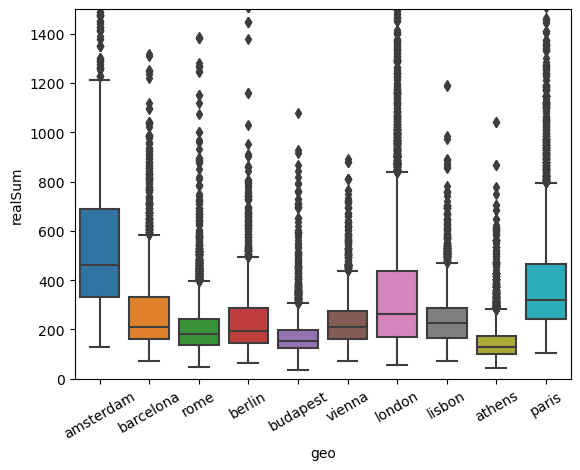

<Figure size 640x480 with 0 Axes>

In [13]:
# Plotting the graph
sns.boxplot(x='geo', y='realSum', data=df)
plt.ylim(0, 1500)
plt.xticks(rotation=30)
plt.show()
plt.clf()

We can see that pricing varies from city to city with otliers reaching 18545 euros per two nights. Let's look into the pricing more closely.

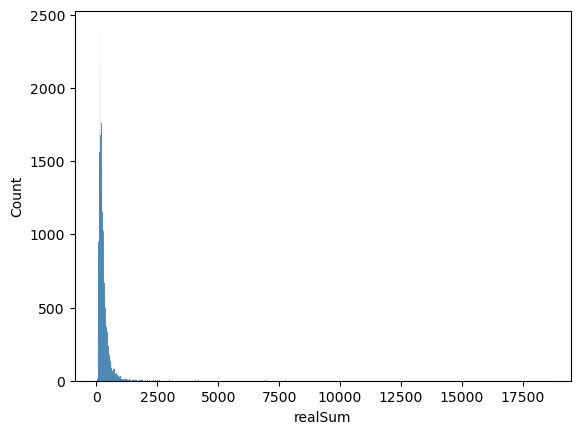

<Figure size 640x480 with 0 Axes>

In [14]:
# Plotting pricing histogram for 99% of the observations
sns.histplot(df['realSum'])
plt.show()
plt.clf()

We see on the graphs that prices have major outliers. Let's see how the graph will react if we display 99% of the observed data.

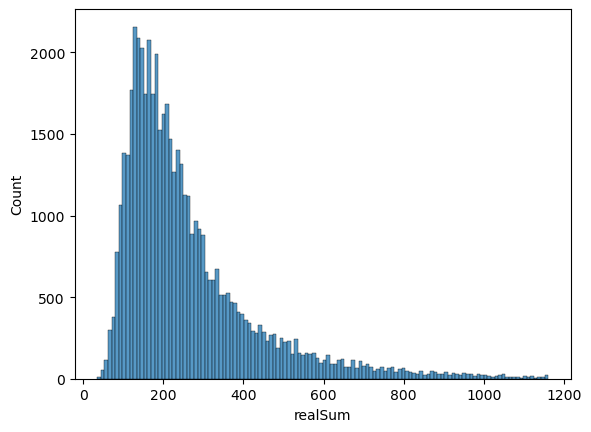

<Figure size 640x480 with 0 Axes>

In [15]:
# Plotting pricing histogram for 99% of the observations
sns.histplot(df['realSum'][df['realSum'] < df['realSum'].quantile(0.99)])
plt.show()
plt.clf()

As we can see on the graph, 99% of the price observations are under 1200 euros per two nights. Prices counts are strongly skewed to the right.

## Building a model
### Getting the data ready
Now that we had a look into the graphs, I will begin creating prediction model.
I will start with transforming categorical data and creating relation heatmap.
I will also get rid of attractive index and restaurant index variables since authors already included standardized version of these variables. Same as before, I will be working with the prices counts under 99th quantile.

In [16]:
# Dropping the outliers
df = df[df['realSum'] < df['realSum'].quantile(0.99)]

# Creating a dataset for a machine learning model and one-hot-encoding categorical data
df_model = pd.get_dummies(df, columns=['room_type', 'geo', 'week'], drop_first=True)

# Dropping not standardized data
df_model = df_model.drop(columns=['attr_index', 'rest_index'], axis=1)

In [17]:
# Checking modified dataset
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50827 entries, 0 to 51340
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     50827 non-null  float64
 1   person_capacity             50827 non-null  float64
 2   host_is_superhost           50827 non-null  bool   
 3   multi                       50827 non-null  int64  
 4   biz                         50827 non-null  int64  
 5   cleanliness_rating          50827 non-null  float64
 6   guest_satisfaction_overall  50827 non-null  float64
 7   bedrooms                    50827 non-null  int64  
 8   dist                        50827 non-null  float64
 9   metro_dist                  50827 non-null  float64
 10  attr_index_norm             50827 non-null  float64
 11  rest_index_norm             50827 non-null  float64
 12  room_type_Private room      50827 non-null  uint8  
 13  geo_athens                  508

Now, that we have created a new dataset for a model, let's look into the correlation matrix and the heatmap buit on top of it.

In [18]:
# Creating a correlation matrix
corr = df_model.corr()
display(corr)

,realSum,person_capacity,host_is_superhost,multi,biz,...,geo_london,geo_paris,geo_rome,geo_vienna,week_weekends
realSum,1.000000,0.313579,-0.075624,-0.085422,0.084860,...,0.176576,0.243296,-0.161424,-0.050164,0.026077
person_capacity,0.313579,1.000000,0.033467,-0.054167,0.106949,...,-0.125682,-0.069996,0.075657,0.043811,-0.011404
host_is_superhost,-0.075624,0.033467,1.000000,0.097506,-0.107775,...,-0.111615,-0.102004,0.074362,0.017380,-0.006085
multi,-0.085422,-0.054167,0.097506,1.000000,-0.470479,...,-0.018621,-0.061471,0.095296,-0.008465,-0.005246
biz,0.084860,0.106949,-0.107775,-0.470479,1.000000,...,0.038469,-0.087557,-0.014125,-0.005061,-0.017569
...,...,...,...,...,...,...,...,...,...,...,...
geo_london,0.176576,-0.125682,-0.111615,-0.018621,0.038469,...,1.000000,-0.186125,-0.225891,-0.132813,0.030703
geo_paris,0.243296,-0.069996,-0.102004,-0.061471,-0.087557,...,-0.186125,1.000000,-0.177245,-0.104212,0.020344
geo_rome,-0.161424,0.075657,0.074362,0.095296,-0.014125,...,-0.225891,-0.177245,1.000000,-0.126477,-0.003764
geo_vienna,-0.050164,0.043811,0.017380,-0.008465,-0.005061,...,-0.132813,-0.104212,-0.126477,1.000000,0.001105


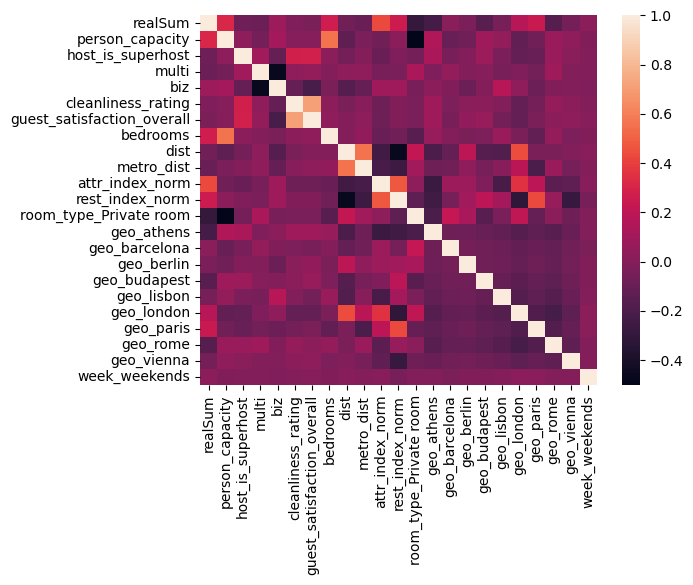

In [19]:
# Plotting a heatmap
sns.heatmap(corr)
plt.show()

On the heatmap we can see that cleanliness rating and guest satisfaction rating are correlating at a high level of 0.71. I will drop the variable with a less impact on the final price.

In [20]:
# dropping cleanliness rating
df_model = df_model.drop(columns=['cleanliness_rating'], axis=1)

### Finding a baseline
Now, that we only have the data we need for a model, we can start training it. I have chosen random forest regressor for this project since it shows good results for datasets this big.<br>
<br>
But before we build the model, there is one question to answer: "How do we know if the model performs good?".<br>
To answer this question we need a baseline for reference. If a model performs better than this baseline, it is safe to say that the model is succesful.<br>
<br>
For the baseline I have chosen average prices across the cities. In other words, baseline for evaluating the model will be mean squared error and r2 score, as if we have predicted each airbnb price to be the same as the average price for this city.

In [54]:
# Features and labels for model
features_model = df_model.drop(columns=['realSum'], axis=1)
labels_model = df_model['realSum']

# Features and labels of all the data
features = df.drop(columns=['realSum'], axis=1)
labels = df['realSum']

In [22]:
# Creating train and test split
train_features, test_features, train_labels, test_labels = train_test_split(features_model, labels_model, test_size=0.2, random_state=23)

train_features_base, test_features_base, train_labels_base, test_labels_base = train_test_split(features, labels, test_size=0.2, random_state=23)


In [23]:
# Baseline predictions by geo
baseline_preds = test_features_base['geo'].apply(lambda x: df['realSum'][df['geo'] == x].mean())
avg_baseline_errors = mean_squared_error(test_labels_base, baseline_preds)

In [24]:
# Displaying baseline
display(f'Baseline mean squared error: {avg_baseline_errors}')
display(f'Baseline r2 score: {r2_score(test_labels_base, baseline_preds)}')

'Baseline mean squared error: 20857.969025163806'

'Baseline r2 score: 0.2489019157784581'

### Training model
Now that we know our baseline we can start training a model. I will instantiate random forest regressor and measure how well it performs.

In [25]:
# Instantiating random forest regressor
regressor = RandomForestRegressor(random_state=23)

In [26]:
# Training the model
regressor.fit(train_features, train_labels)
labels_pred = regressor.predict(test_features)
display(f'Model mean squared error: {mean_squared_error(test_labels, labels_pred)}')
display(f'Model r2 score: {regressor.score(test_features, test_labels)}')

'Model mean squared error: 5543.155042160142'

'Model r2 score: 0.8003902907475544'

We see that the model performs much better than the baseline. But can we tune it to do even better?

### Tuning the model
To tune the model's hyperparameters I will use "RandomizedSearchCV" class. The problem is  this method requires a lot of computational power when used with big datasets such as ours. To solve this problem I will sample the data. This way this method will still take a lot of time but at least it will be doable.

In [27]:
# Random sampling
sample = df_model.sample(12000, random_state=23)

In [28]:
# Making sets of features and labels
sample_features = sample.drop(columns=['realSum'], axis=1)
sample_labels = sample['realSum']

In [29]:
# Splitting the data to train and test
train_features_sample, test_features_sample, train_labels_sample, test_labels_sample = train_test_split(sample_features, sample_labels, test_size=0.2)

In [30]:
# Checking how well stanrard regressor performs on the sample
regressor.fit(train_features_sample, train_labels_sample)
labels_pred_sample = regressor.predict(test_features_sample)
display(f'Sample mean squared error: {mean_squared_error(test_labels_sample, labels_pred_sample)}')
display(f'Sample r2 score{r2_score(test_labels_sample, labels_pred_sample)}')

'Sample mean squared error: 9104.669284208334'

'Sample r2 score0.6705270662266485'

We see that the model performs worse on the sample data. But if we will be able to tune the model here, then same hyperparameters should work on the main data.

In [31]:
# Instantiating a random grid with hyperparameters
n_estimators = [int(x) for x in np.linspace(200, 2000, 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 70, 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

In [32]:
# Instantiating the RandomizedSearchCV
rf_random = RandomizedSearchCV(regressor, 
                               param_distributions=random_grid, 
                               n_iter=100, 
                               cv=5, 
                               random_state=23, 
                               verbose=3, 
                               n_jobs=-1
                              )

In the code above I used "verbose=3" in case my computer won't be able to make the computations.

In [33]:
# Fitting the data
rf_random.fit(train_features_sample, train_labels_sample)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=0.489 total time=   8.3s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1100;, score=0.568 total time=   4.8s
[CV 1/5] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=650;, score=0.667 total time=   5.2s


/Users/klimgruzdev/anaconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=650;, score=0.622 total time=   4.1s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=650;, score=0.629 total time=   4.2s
[CV 1/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1100;, score=0.597 total time=   4.8s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1100;, score=0.617 total time=   4.8s
[CV 2/5] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=650;, score=0.684 total time=   5.4s
[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=650;, score=0.613 total time=   4.2s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_

[CV 3/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=650;, score=0.582 total time=   4.2s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1550;, score=0.650 total time=  35.4s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=650;, score=0.659 total time=  14.2s
[CV 5/5] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2000;, score=0.516 total time= 1.3min
[CV 3/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1100;, score=0.627 total time=  30.0s
[CV 4/5] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=650;, score=0.463 total time=  25.4s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=auto, min_samp

[CV 4/5] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=650;, score=0.480 total time=  26.1s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.577 total time=  34.6s
[CV 2/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=650;, score=0.659 total time=   4.4s
[CV 5/5] END bootstrap=True, max_depth=55, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=650;, score=0.664 total time=   4.4s
[CV 4/5] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.653 total time=   5.1s
[CV 3/5] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1550;, score=0.326 total time= 1.3min
[CV 3/5] END bootstrap=False, max_depth=None, max_features=sqrt, min_samp

[CV 4/5] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=650;, score=0.691 total time=   8.0s
[CV 2/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.666 total time=  54.6s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.519 total time=  34.1s
[CV 2/5] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1100;, score=0.669 total time=  30.1s
[CV 5/5] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1100;, score=0.671 total time=  30.5s
[CV 4/5] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000;, score=0.684 total time=  21.3s
[CV 1/5] END bootstrap=False, max_depth=55, max_features=auto, min_s

[CV 1/5] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.670 total time=  12.6s
[CV 5/5] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1100;, score=0.689 total time=  12.8s
[CV 3/5] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1100;, score=0.621 total time=  27.7s
[CV 1/5] END bootstrap=True, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1100;, score=0.647 total time=  27.4s
[CV 3/5] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1550;, score=0.624 total time=  10.2s
[CV 1/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1550;, score=0.656 total time=  45.1s
[CV 5/5] END bootstrap=True, max_depth=40, max_features=auto, min_samples

[CV 1/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1100;, score=0.604 total time=   7.7s
[CV 4/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1100;, score=0.623 total time=   7.7s
[CV 2/5] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000;, score=0.661 total time=  49.4s
[CV 3/5] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1550;, score=0.369 total time= 1.2min
[CV 4/5] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1100;, score=0.463 total time=  43.4s
[CV 2/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1100;, score=0.615 total time=   7.7s
[CV 5/5] END bootstrap=False, max_depth=10, max_features=sqrt, min_

[CV 4/5] END bootstrap=False, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000;, score=0.403 total time= 1.5min
[CV 2/5] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.500 total time=   8.4s
[CV 5/5] END bootstrap=False, max_depth=55, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.500 total time=   8.5s
[CV 3/5] END bootstrap=True, max_depth=25, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1550;, score=0.630 total time=  42.4s
[CV 4/5] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=2000;, score=0.662 total time= 1.1min
[CV 2/5] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1550;, score=0.500 total time= 1.1min
[CV 1/5] END bootstrap=False, max_depth=70, max_features=sqrt, min_sa

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=23),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 25, 40, 55, 70, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 650, 1100, 1550,
                                                         2000]},
                   random_state=23, verbose=3)

Now let's look at the best estimators and it's score:

In [38]:
# Displaying the results
display(rf_random.best_estimator_)
display(rf_random.best_score_)

RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      n_estimators=650, random_state=23)

0.684919461628757

***
The model performs 1% better with these hyperparameters. Let's see if the model will do the same with the whole dataset.

In [42]:
# Instantiating new model
regressor_tweaked = RandomForestRegressor(
    bootstrap=False, 
    max_depth=70, 
    max_features='sqrt', 
    n_estimators=650, 
    random_state=23
)

In [43]:
# Fitting the new model
regressor_tweaked.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      n_estimators=650, random_state=23)

In [57]:
# Printing score
tweaked_score = regressor_tweaked.score(test_features, test_labels)
print(f'Score: {tweaked_score}')

Score: 0.8115511243147494


In [56]:
# Printing mean squared error
labels_tweaked_pred = regressor_tweaked.predict(test_features)

display(f'Mean squared error: {mean_squared_error(test_labels, labels_tweaked_pred)}')

'Mean squared error: 5233.219062119888'

We see that the model itself also improved it's score by more than 1%. It is possible to increase this number even more by using GridSearchCV to tune the model.

## Inspecting feature importance
Now let's look into the decision trees of our random forest, so the model would be less of a black box it is now.

In [52]:
# Printing feature importances
feature_importances = list(zip(regressor_tweaked.feature_names_in_, regressor_tweaked.feature_importances_))
display('Feature importances:')
display(feature_importances)

'Feature importances:'

[('person_capacity', 0.07515713529143728),
 ('host_is_superhost', 0.008391976645237631),
 ('multi', 0.008632126517995251),
 ('biz', 0.01349921632634647),
 ('guest_satisfaction_overall', 0.048009137921399846),
 ('bedrooms', 0.09013682883712103),
 ('dist', 0.08895192739181759),
 ('metro_dist', 0.07237361196177233),
 ('attr_index_norm', 0.20689605277565332),
 ('rest_index_norm', 0.09966573501062367),
 ('room_type_Private room', 0.06838657821660883),
 ('geo_athens', 0.03893545523013995),
 ('geo_barcelona', 0.009962131224514247),
 ('geo_berlin', 0.008876957108183564),
 ('geo_budapest', 0.03843986063637368),
 ('geo_lisbon', 0.013186908984639189),
 ('geo_london', 0.03706174453695912),
 ('geo_paris', 0.03130574276648652),
 ('geo_rome', 0.0294134317251337),
 ('geo_vienna', 0.006946824177501454),
 ('week_weekends', 0.005770616714055382)]

## Overview
The project aimed to predict Airbnb prices in Europe using machine learning algorithm. The random forest regressor model performed well having <b>mean squared score of 5233</b> and <b>R2 score of 0.81</b>. However, there is still room for improvement. Techniques like GridSearchCV can be used to fine-tune the model's hyperparameters. Additionally, incorporating other relevant features and exploring alternative algorithms and ensemble methods could further enhance the accuracy of predictions. Overall, the project provides valuable insights for Airbnb hosts and travelers in the European market, with potential for further refinement and optimization.